In [7]:
# Warehous Inventory Optimization : Avoiding overstocking problem by demannd forecasting  and 
# setting inventory levels based on predicted demand and safety stock

In [8]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

In [9]:
df = pd.read_csv("online_retail.csv", encoding='ISO-8859-1')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df = df[df['Quantity'] > 0]  # remove returns

# Filter by stock code
stock_code = '84029E'
df_item = df[df['StockCode'] == stock_code]

# Daily quantity
daily_sales = df_item.groupby(df_item['InvoiceDate'].dt.date)['Quantity'].sum()
daily_sales.index = pd.to_datetime(daily_sales.index)
# Load data
df = pd.read_csv("online_retail.csv", encoding='ISO-8859-1')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df = df[df['Quantity'] > 0]  # remove returns

# Filter a particular StockCode
stock_code = '84029E'
df_item = df[df['StockCode'] == stock_code]

# Aggregate daily quantity
daily_sales = df_item.groupby(df_item['InvoiceDate'].dt.date)['Quantity'].sum()
daily_sales.index = pd.to_datetime(daily_sales.index)
daily_sales = daily_sales.asfreq('D').fillna(0)  # fill missing days


ARIMA RMSE: 5.888031837457991
ARIMA MAPE: 0.033783783783783786


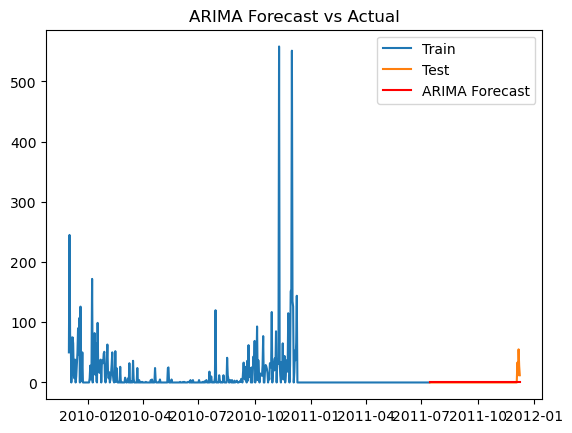

In [10]:
# ARIMA

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Split data
train_size = int(len(daily_sales) * 0.8)
train, test = daily_sales[:train_size], daily_sales[train_size:]

# Fit ARIMA
model = ARIMA(train, order=(5, 1, 0))  # You can auto-tune this later
model_fit = model.fit()
forecast_arima = model_fit.forecast(steps=len(test))

# Error Metrics
rmse_arima = np.sqrt(mean_squared_error(test, forecast_arima))
mape_arima = mean_absolute_percentage_error(test, forecast_arima)

print("ARIMA RMSE:", rmse_arima)
print("ARIMA MAPE:", mape_arima)

# Optional: Plot
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(test.index, forecast_arima, label='ARIMA Forecast', color='red')
plt.legend()
plt.title("ARIMA Forecast vs Actual")
plt.show()


XGBoost RMSE: 5.018588306082225
XGBoost MAPE: 0.9604201638818992


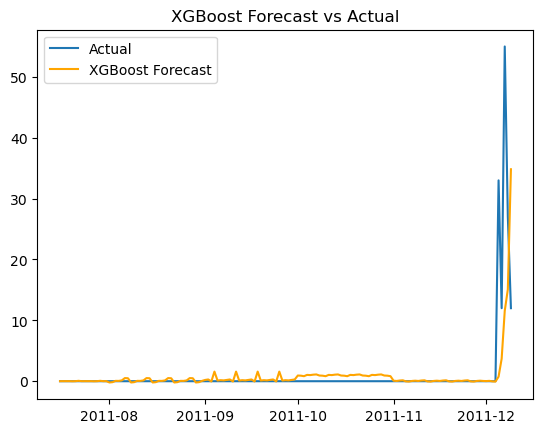

In [13]:
#XGBOOST

# Prepare features
df_feat = daily_sales.reset_index()
df_feat.columns = ['date', 'quantity']
df_feat['dayofweek'] = df_feat['date'].dt.dayofweek
df_feat['month'] = df_feat['date'].dt.month
df_feat['lag_1'] = df_feat['quantity'].shift(1)
df_feat['rolling_mean_7'] = df_feat['quantity'].rolling(7).mean()
df_feat.dropna(inplace=True)

# Split
train_size = int(len(df_feat) * 0.8)
train_xgb = df_feat.iloc[:train_size]
test_xgb = df_feat.iloc[train_size:]

X_train = train_xgb[['dayofweek', 'month', 'lag_1', 'rolling_mean_7']]
y_train = train_xgb['quantity']
X_test = test_xgb[['dayofweek', 'month', 'lag_1', 'rolling_mean_7']]
y_test = test_xgb['quantity']

# Train
model_xgb = XGBRegressor()
model_xgb.fit(X_train, y_train)
y_pred_xgb = model_xgb.predict(X_test)

# Error Metrics
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

# Filter out zero-actuals
nonzero_mask = y_test != 0
filtered_y_test = y_test[nonzero_mask]
filtered_y_pred = y_pred_xgb[nonzero_mask]

mape_xgb = mean_absolute_percentage_error(filtered_y_test, filtered_y_pred)

print("XGBoost RMSE:", rmse_xgb)
print("XGBoost MAPE:", mape_xgb)

# Optional: Plot
plt.plot(test_xgb['date'], y_test, label='Actual')
plt.plot(test_xgb['date'], y_pred_xgb, label='XGBoost Forecast', color='orange')
plt.legend()
plt.title("XGBoost Forecast vs Actual")
plt.show()